# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link:https://drive.google.com/file/d/1EnHcrTIMvzELTj93zoCHWo1yVrQNnqd9/view?usp=sharing

As we are using the older version of the torchtext, please run the following to downgrade the torchtext version:

!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
!pip install -U torchtext==0.6
!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install -U torchtext==0.6


Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.8.0+cu111 (from versions: 1.11.0, 1.11.0+cpu, 1.11.0+cu102, 1.11.0+cu113, 1.11.0+cu115, 1.11.0+rocm4.3.1, 1.11.0+rocm4.5.2, 1.12.0, 1.12.0+cpu, 1.12.0+cu102, 1.12.0+cu113, 1.12.0+cu116, 1.12.0+rocm5.0, 1.12.0+rocm5.1.1, 1.12.1, 1.12.1+cpu, 1.12.1+cu102, 1.12.1+cu113, 1.12.1+cu116, 1.12.1+rocm5.0, 1.12.1+rocm5.1.1, 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.0+rocm5.1.1, 1.13.0+rocm5.2, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 1.13.1+rocm5.1.1, 1.13.1+rocm5.2, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.0+cu117.with.pypi.cudnn, 2.0.0+cu118, 2.0.0+rocm5.3, 2.0.0+rocm5.4.2, 2.0.1, 2.0.1+cpu, 2.0.1+cpu.cxx11.abi, 2.0.1+cu117, 2.0.1+cu117.with.pypi.cudnn, 2.0.1+cu118, 2.0.1+rocm5.3, 2.0.1+rocm5.4.2)
ERROR: No matching distribution found for torch==1.8.0+cu111


If you are interested to use the most recent version if torchtext, you can look

*   List item
*   List item

at the following document to see how to convert the legacy version to the new version:
https://colab.research.google.com/github/pytorch/text/blob/master/examples/legacy_tutorial/migration_tutorial.ipynb

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
master_path = '/content/drive/My Drive/APS360/SMSSpamCollection'
for line in open(master_path):
  if line[0] == 'h':
    print(line)
    break
for line in open(master_path):
  if line[0] == 's':
    print(line)
    break


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
ns = 0
s = 0
for line in open(master_path):
  if line[0] == 'h':
    ns+=1
  if line[0] == 's':
    s+=1
print("Num of non-spam", ns)
print("Num of spam", s)


Num of non-spam 4827
Num of spam 747


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

In [ ]:
#Advantages:
#1. Less characters than words
#2. do not need complex tokenization
#Disadvantages:
#1. Requires more computation (harder to train)
#2. Hard to understand longer texts

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file.

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file.
In our case, the dataset has two fields:

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [ ]:
import torchtext

text_field = torchtext.data.Field(sequential=True,
                                  tokenize=lambda x: x,
                                  include_lengths=True,
                                  batch_first=True,
                                  use_vocab=True)
label_field = torchtext.data.Field(sequential=False,
                                   use_vocab=False,
                                   is_target=True,
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam'))

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.data.TabularDataset(master_path, "tsv", fields)
test, valid, train = dataset.split(split_ratio=[0.6, 0.2, 0.2])

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [ ]:
#The importance of having a balanced dataset is to advoid bias and improve accuracy and advoid miscalssification errors.

# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [ ]:
text_field.build_vocab(train)
#text_field.vocab.stoi: (string to integer) is a dictionary that maps each word in the vocabulary to a index
#text_field.vocab.itos: (integer to string) is a list where each index corresponds to the vocabulary at that index. Reverse mapping of stoi.

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

In [ ]:
#they represent unknown(used to remove words that are seldomely used) and padding (used to make each message the same length)

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [ ]:
train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs


In [ ]:
valid_iter = torchtext.data.BucketIterator(valid,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

test_iter = torchtext.data.BucketIterator(test,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
count = 0
for batch in train_iter:
    print(batch.sms[1].max())
    print((batch.sms[1].max() - batch.sms[1]).sum())
    count+=1
    if count == 10:
      break

tensor(92)
tensor(107)
tensor(40)
tensor(42)
tensor(52)
tensor(66)
tensor(115)
tensor(40)
tensor(69)
tensor(92)
tensor(64)
tensor(55)
tensor(42)
tensor(37)
tensor(47)
tensor(38)
tensor(790)
tensor(10151)
tensor(153)
tensor(23)


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing.
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a
fully-connected
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
class simpleRNN(nn.Module):
  def __init__(self, vocab, hidden, layers):
    super(simpleRNN, self).__init__()
    self.ident = torch.eye(vocab)
    self.rnn = nn.GRU(vocab, hidden, layers, batch_first=True)
    self.classifier = nn.Linear(hidden, 2)

  def forward(self, x):
    one_hot = [self.ident[sms] for sms in x]
    inp_x = torch.stack(one_hot)
    output, _ = self.rnn(inp_x)
    max_pool_output = torch.max(output, dim=1)[0]
    final_output = self.classifier(max_pool_output)
    return final_output

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [ ]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`

    Example usage:

    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    correct, total = 0, 0
    for sms, labels in data:
        output = model(sms[0])
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total



### Part (b) [4 pt]

Train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest.

Epoch 1; Loss 0.668222; Train Acc 0.486925; Val Acc 0.121973
Epoch 2; Loss 0.714591; Train Acc 0.486925; Val Acc 0.121973
Epoch 3; Loss 0.699286; Train Acc 0.540272; Val Acc 0.216143
Epoch 4; Loss 0.655535; Train Acc 0.865063; Val Acc 0.770404
Epoch 5; Loss 0.655075; Train Acc 0.898013; Val Acc 0.837668
Epoch 6; Loss 0.647540; Train Acc 0.948745; Val Acc 0.964126
Epoch 7; Loss 0.608970; Train Acc 0.948745; Val Acc 0.961435
Epoch 8; Loss 0.550465; Train Acc 0.953975; Val Acc 0.947085
Epoch 9; Loss 0.540594; Train Acc 0.925209; Val Acc 0.968610
Epoch 10; Loss 0.325624; Train Acc 0.930439; Val Acc 0.969507
Epoch 11; Loss 0.321564; Train Acc 0.932531; Val Acc 0.977578
Epoch 12; Loss 0.393528; Train Acc 0.931485; Val Acc 0.971300
Epoch 13; Loss 0.371486; Train Acc 0.927301; Val Acc 0.900448
Epoch 14; Loss 0.532804; Train Acc 0.916841; Val Acc 0.976682
Epoch 15; Loss 0.148010; Train Acc 0.926255; Val Acc 0.977578
Epoch 16; Loss 0.190379; Train Acc 0.929393; Val Acc 0.977578
Epoch 17; Loss 0.

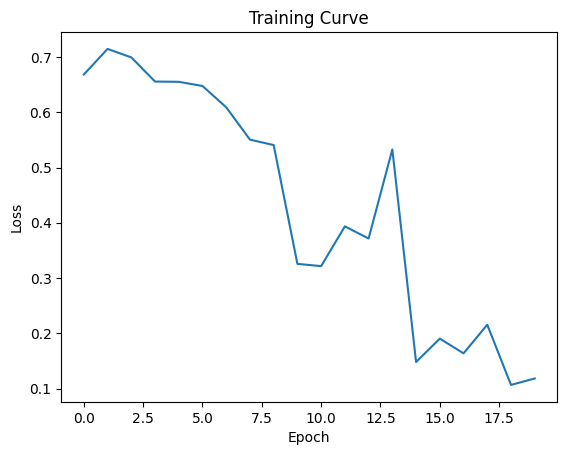

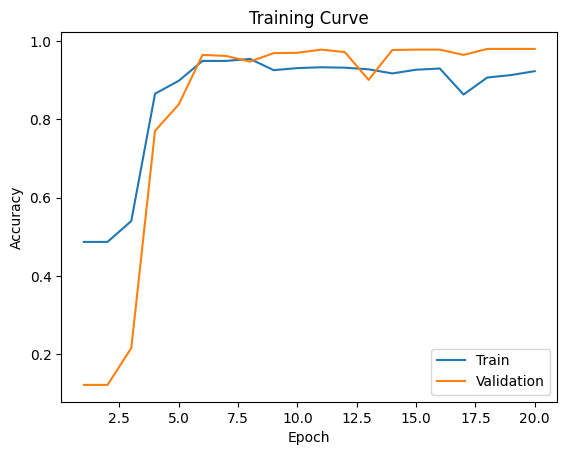

In [ ]:
import matplotlib.pyplot as plt

def train_rnn(model, train_d, valid_d, epochs, learning_rate):
    opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    iteration = 0
    loss_values, train_accuracy, validation_accuracy = [], [], []
    epoch_list = []
    for epoch in range(epochs):
        average_loss = 0
        for message, label in train_d:
            opt.zero_grad()
            prediction = model(message[0])
            loss = loss_fn(prediction, label)
            loss.backward()
            opt.step()

        loss_values.append(float(loss))
        epoch_list.append(epoch + 1)
        train_accuracy.append(get_accuracy(model, train_d))
        validation_accuracy.append(get_accuracy(model, valid_d))
        print(f"Epoch {epoch + 1}; Loss {loss:.6f}; Train Acc {train_accuracy[-1]:.6f}; Val Acc {validation_accuracy[-1]:.6f}")

    # plotting
    plt.title("Training Curve")
    plt.plot(loss_values, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epoch_list, train_accuracy, label="Train")
    plt.plot(epoch_list, validation_accuracy, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()


RNN_1 = simpleRNN(len(text_field.vocab.itos), layers = 1)
train_rnn(RNN_1, train_iter, valid_iter, 20, 1e-4)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

Epoch 1; Loss 0.635075; Train Acc 0.513075; Val Acc 0.878027
Epoch 2; Loss 0.641514; Train Acc 0.513075; Val Acc 0.878027
Epoch 3; Loss 0.739245; Train Acc 0.513075; Val Acc 0.878027
Epoch 4; Loss 0.727303; Train Acc 0.513075; Val Acc 0.878027
Epoch 5; Loss 0.697250; Train Acc 0.513075; Val Acc 0.878027
Epoch 6; Loss 0.673849; Train Acc 0.513075; Val Acc 0.878027
Epoch 7; Loss 0.639641; Train Acc 0.513075; Val Acc 0.878027
Epoch 8; Loss 0.643830; Train Acc 0.531381; Val Acc 0.880717
Epoch 9; Loss 0.645892; Train Acc 0.604079; Val Acc 0.894170
Epoch 10; Loss 0.673642; Train Acc 0.675209; Val Acc 0.906726
Epoch 11; Loss 0.665548; Train Acc 0.776151; Val Acc 0.928251
Epoch 12; Loss 0.676042; Train Acc 0.799163; Val Acc 0.937220
Epoch 13; Loss 0.680844; Train Acc 0.837866; Val Acc 0.954260
Epoch 14; Loss 0.662342; Train Acc 0.906381; Val Acc 0.970404
Epoch 15; Loss 0.643068; Train Acc 0.930962; Val Acc 0.974888
Epoch 16; Loss 0.634629; Train Acc 0.934623; Val Acc 0.975785
Epoch 17; Loss 0.

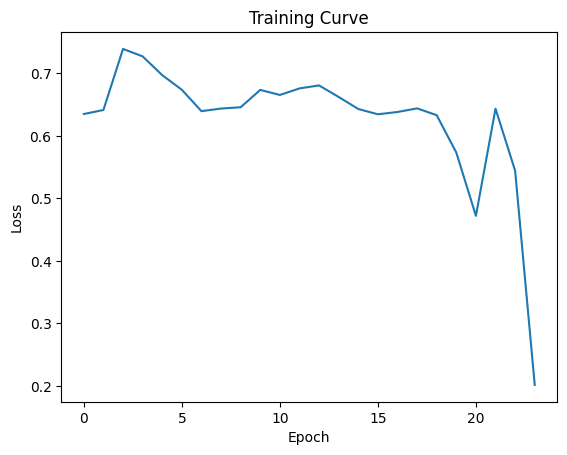

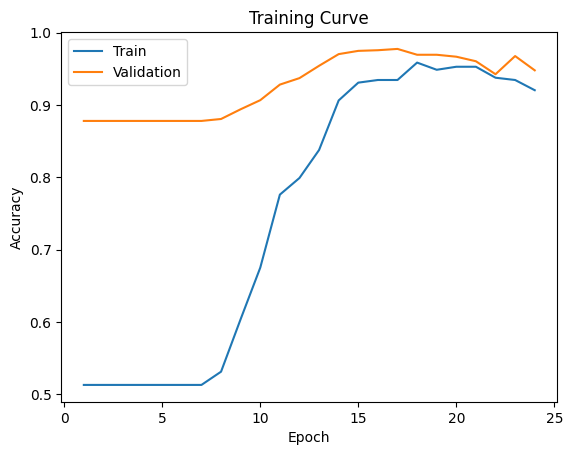

In [ ]:
import torchtext
train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=64,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs


valid_iter = torchtext.data.BucketIterator(valid,
                                           batch_size=64,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

test_iter = torchtext.data.BucketIterator(test,
                                           batch_size=64,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs


import matplotlib.pyplot as plt

def train_rnn(model, train_d, valid_d, epochs, learning_rate):
    opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    iteration = 0
    loss_values, train_accuracy, validation_accuracy = [], [], []
    epoch_list = []
    for epoch in range(epochs):
        average_loss = 0
        for message, label in train_d:
            opt.zero_grad()
            prediction = model(message[0])
            loss = loss_fn(prediction, label)
            loss.backward()
            opt.step()

        loss_values.append(float(loss))
        epoch_list.append(epoch + 1)
        train_accuracy.append(get_accuracy(model, train_d))
        validation_accuracy.append(get_accuracy(model, valid_d))
        print(f"Epoch {epoch + 1}; Loss {loss:.6f}; Train Acc {train_accuracy[-1]:.6f}; Val Acc {validation_accuracy[-1]:.6f}")

    # plotting
    plt.title("Training Curve")
    plt.plot(loss_values, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epoch_list, train_accuracy, label="Train")
    plt.plot(epoch_list, validation_accuracy, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()


RNN_2 = simpleRNN(len(text_field.vocab.itos), hidden = 64, layers = 1)
train_rnn(RNN_2, train_iter, valid_iter, 24, 1e-4)

In [ ]:
#Epoch = 16, lr = le-4, bs = 32, hs = 32 -- Val Acc 0.934529: This configuration provides a decent validation accuracy. It indicates that the model has been adequately trained and is able to generalize well to unseen data.
#Epoch = 24, lr = le-5, bs = 32, hs = 32 -- Val Acc stuck at 0.121973: This low validation accuracy indicates that the model is not learning effectively. The learning rate might be too small in this case, causing the model to learn too slowly. Think it needs way more epochs.
#Epoch = 24, lr = le-4, bs = 64, hs = 64 -- 0.977578:  This setup gives the highest validation accuracy among all configurations. Model seems to generalize pretty well.
#Epoch = 24, lr = le-4, bs = 128, hs = 128 -- Val Acc 0.964126: This setup's main goal is to improve on the previous one, but a batch size of 128 and hidden size of 128 seems to reduce the models ability to generalize and cause overfitting




### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)

valid_spam_iter = torchtext.data.BucketIterator(valid_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)

valid_nospam_iter = torchtext.data.BucketIterator(valid_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

fp_rate = 1 - get_accuracy(RNN_2, valid_nospam_iter)
fn_rate = 1 - get_accuracy(RNN_2, valid_spam_iter)
print("fp rate: ", fp_rate)
print("fn rate: ", fn_rate)

fp rate:  0.051072522982635316
fn rate:  0.06617647058823528


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

In [ ]:
#false positive means that a non-spam would be seen as a span. As a result, the user could miss important messages.
#false negative means that a span would be seen as a non-spam. As a result, the user would be shown useless information.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [ ]:
acc = get_accuracy(RNN_2, test_iter)
print(acc)
#93.7%

0.936583906670655


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)

valid_spam_iter = torchtext.data.BucketIterator(valid_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)

valid_nospam_iter = torchtext.data.BucketIterator(valid_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

fp_rate = 1 - get_accuracy(RNN_2, valid_nospam_iter)
fn_rate = 1 - get_accuracy(RNN_2, valid_spam_iter)
print("fp rate: ", fp_rate)
print("fn rate: ", fn_rate)

fp rate:  0.06352530541012213
fn rate:  0.060669456066945626


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [ ]:
msg = "Machine learning is super interesting!"
tokenized_msg = [torch.tensor(text_field.vocab.stoi[char]) for char in msg]

x = torch.stack(tokenized_msg).unsqueeze_(0)

spam_prob = F.softmax(RNN_2(x), dim=1)[0][1].item()
print("Likelyhood of being a spam:", spam_prob)


Likelyhood of being a spam: 0.4105496108531952


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

In [ ]:
'''
One reason which makes a model hard to detect spam is due to the complexity of the human language. Moreover, a spam for one person might be a useful letter for another, as people have different hobbies,
preferences, and interests. Moreoever, it could also be that the people who are creating the spam messages are very skilled in doing so, and they may also use a ML model to check the quality of their spam.

Baseline: Simple Neural Network
The inputs will be the embedding of the words and the output would be a binary clasification. The weights would automaticially change, and the hyperparamerts as well as the layers inside can also be modified for best results.








'''




